# fastbook 05_pet_breeds
> Not done

- toc:true
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [fastbook, pet breeds]

ref: https://github.com/fastai/fastbook

In [1]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *

## Image Classification

- Make them better.
- Apply them to a wider variety of types of data.

## From Dogs and Cats to Pet Breeds

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

- Individual files representing items of data, such as text documents or images, possibly organized into folders or with filenames representing information about those items
- A table of data, such as in CSV format, where each row is an item which may include filenames providing a connection between the data in the table and data in other formats, such as text documents and images

 the vast majority of the datasets you'll work with will use some combination of these two formats.

In [7]:
Path.BASE_PATH = path

In [8]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [10]:
(path/"images").ls()

(#7393) [Path('images/Bombay_13.jpg'),Path('images/beagle_193.jpg'),Path('images/Ragdoll_8.jpg'),Path('images/boxer_106.jpg'),Path('images/keeshond_56.jpg'),Path('images/american_pit_bull_terrier_162.jpg'),Path('images/saint_bernard_136.jpg'),Path('images/staffordshire_bull_terrier_76.jpg'),Path('images/pug_173.jpg'),Path('images/american_pit_bull_terrier_117.jpg')...]

By examining these filenames, we can see how they appear to be structured. Each filename contains the pet breed, and then an underscore (_), a number, and finally the file extension.

We need to create a piece of code that extracts the breed from a single Path

In [11]:
fname = (path/"images").ls()[0]

So head over to Google and search for "regular expressions tutorial" now, and then come back here after you've had a good look around. 

When you are writing a regular expression, the best way to start is just to try it against one example at first. 

Let's use the `findall` method to try a regular expression against the filename of the `fname` object:

In [13]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Bombay']

For labeling with regular expressions, we can use the `RegexLabeller` class.

In [15]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

One important piece of this DataBlock call that we haven't seen before is in these two lines:
```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```
- These lines implement a fastai data augmentation strategy which we call presizing. 
- Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

## Presizing

presizing adopts two strategies
1. Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions.
2. Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

- The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. 
- This transformation works by resizing to a square, using a large crop size.
- On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

- In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

In [25]:
![][https://github.com/fastai/fastbook/raw/e57e3155824c81a54f915edf9505f64d5ccdad84//images/att_00060.png]

/bin/bash: [][https://github.com/fastai/fastbook/raw/e57e3155824c81a54f915edf9505f64d5ccdad84//images/att_00060.png]: No such file or directory


*This picture shows the two steps:*
1. *Crop full width or height: This is in item_tfms, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.*
2. *Random crop and augment: This is in batch_tfms, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.*

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

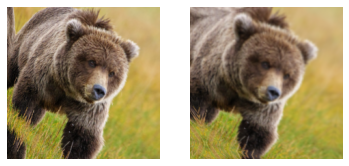

In [33]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

- You can see that the image on the right is less well defined and has reflection padding artifacts in the bottom-left corner; 
- also, the grass at the top left has disappeared entirely. 
- We find that in practice using presizing significantly improves the accuracy of models, and often results in speedups too.

*The fastai library also provides simple ways to check your data looks right before training a model, which is an extremely important step.*

## Checking and Debugging a DataBlock

- Writing a DataBlock is just like writing a blueprint.
- before training a model you should always check your data. 
- You can do this using the show_batch method:

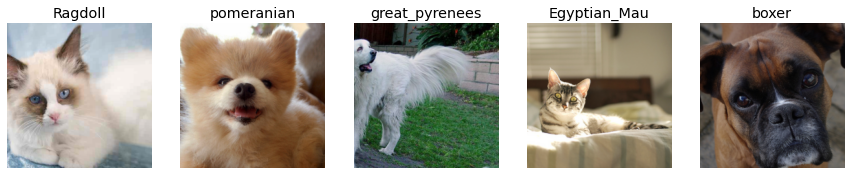

In [35]:
dls.show_batch(nrows=1, ncols=5)